<a href="https://colab.research.google.com/github/deepaskori/Fit-Check-2.0/blob/main/Fit_Check_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 1: Isolating clothing using Meta's SegmentAnything model

In [1]:
%pip install bs4
%pip install requests
%pip install colormath

  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39407 sha256=f26adbb65dcfdf41b3e5375ac333abfa22502842bf66f1ee3a7231aa61bc5f88
  Stored in directory: /root/.cache/pip/wheels/ab/b3/4d/c0738759c25a1df01958068f162cf2a9dc3ab1da8b972cfcfc
Successfully built colormath


In [2]:
import os
import requests
from bs4 import BeautifulSoup
from google.colab import files as FILE
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import urllib
import torch
import torchvision
import pandas as pd
from sklearn.cluster import KMeans
from PIL import Image
from skimage import io
from colormath.color_objects import LabColor, AdobeRGBColor
from colormath.color_conversions import convert_color
from colormath import color_diff_matrix
from colormath.color_diff import delta_e_cie1976
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
from segment_anything import sam_model_registry, SamPredictor

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-e7c81nn9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-e7c81nn9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=ecd7f2341ff80eef587349349649cb4a8f464deb8e0f054654977a1bbd8b43bd
  Stored in directory: /tmp/pip-ephem-wheel-cache-ns8v84ul/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-05-20 22:45:59--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.1

Inputting link to collection of interest and creating folder

In [3]:
link_to_first_pic = "https://www.firstview.com/collection_image_closeup.php?of=0&collection=3852&image=570490"
folder_name = "fall-2002-ready-to-wear-isabel-marant"
os.mkdir(folder_name)

Scraping for all images and downloading to temporary google colab folder

In [4]:
def get_user_show(url):
  soup = BeautifulSoup(requests.get(url).text, 'html.parser')
  lst = []
  for item in soup.find_all('img'):
    if '.jpg' in item['src']:
      lst.append(item['src'])
  return lst

def retrieve_download(url):
  lst_links = get_user_show(url)
  cut_off = 0
  # while lst_links != []:
  while cut_off <= 10:
    sub1 = "?of="
    sub2 = "&collection"
    idx1 = url.find(sub1)
    idx2 = url.find(sub2)
    curr_idx = int(url[idx1 + len(sub1):idx2])
    link = "https://www.firstview.com/" + lst_links[0]
    resp = urllib.request.urlopen(link)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    file_number = curr_idx
    file_name = folder_name + '/' + str(file_number) + '.png'
    cv2.imwrite(file_name, image)
    curr_idx += 1
    url = url.split(sub1)[0] + sub1 + str(curr_idx) + sub2 + url.split(sub2)[1]
    lst_links = get_user_show(url)
    cut_off += 1
retrieve_download(link_to_first_pic)

Setting up for using SAM model

In [5]:

def show_mask(mask, ax, random_color=False):
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


Aggregating image paths and cv2 images

In [6]:
images = []
for file_name in os.listdir(folder_name):
  image_path = folder_name + '/' + file_name
  image_array = cv2.imread(image_path)
  images.append([image_path,image_array])
images[0][1].shape

(508, 333, 3)

Setting up for using SAM Model

In [7]:
sys.path.append("..")
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

Showing an example of how the SAM Model would work on one image

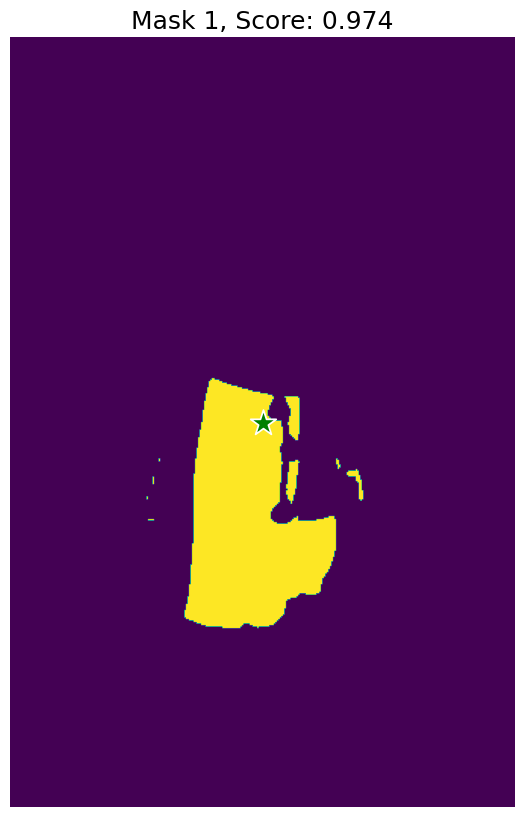

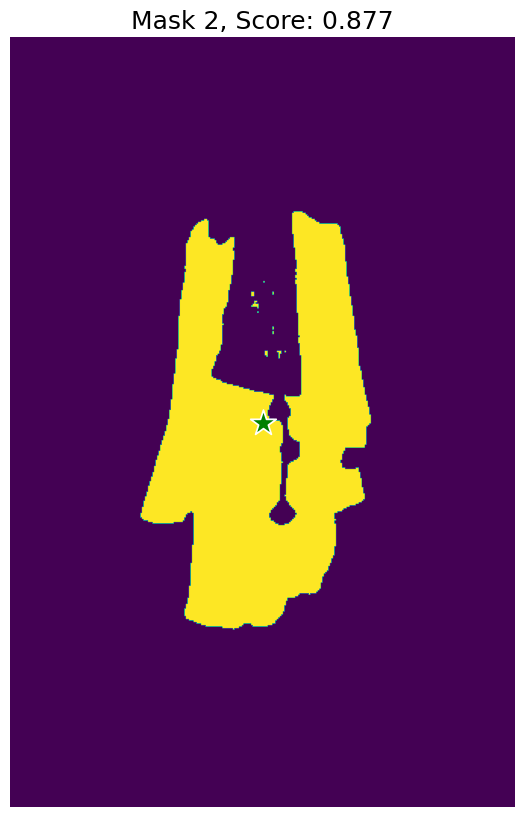

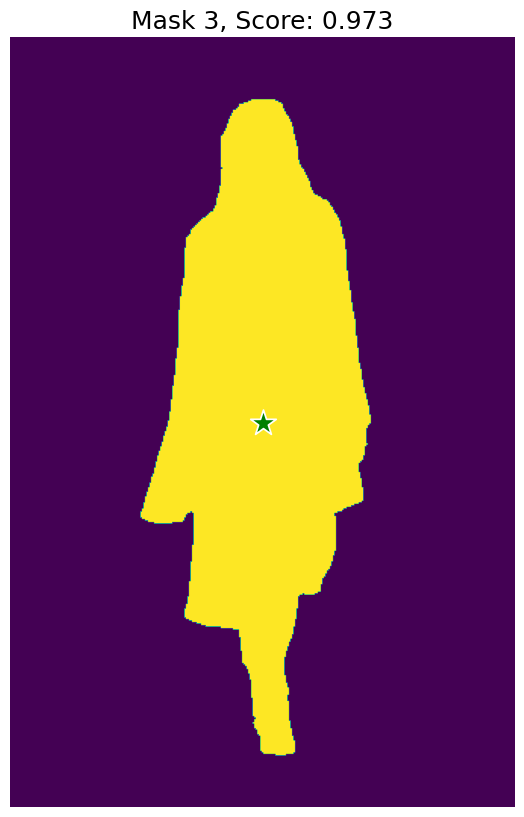

In [8]:
image = images[9][1]
predictor.set_image(image)
input_point = np.array([[image.shape[1]/2, image.shape[0]/2]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
      point_coords=input_point,
      point_labels=input_label,
      multimask_output=True,
  )
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


Converting the SAM Model's 2D mask to 3D mask in order to capture the original colors correctly

In [9]:
def create_mask(image, image_path):
  predictor.set_image(image)
  input_point = np.array([[image.shape[1]/2, image.shape[0]/2]])
  input_label = np.array([1])
  masks, scores, logits = predictor.predict(
      point_coords=input_point,
      point_labels=input_label,
      multimask_output=True,
  )
  oneD_mask = np.where(masks[2] == True, 1, 0)
  twoD_mask =np.dstack((oneD_mask, oneD_mask))
  threeD_mask = np.dstack((oneD_mask, twoD_mask))
  norm_threeD_mask = cv2.normalize(src=threeD_mask, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  print("norm_threeD_mask.shape:", norm_threeD_mask.shape)
  print("image.shape:", image.shape)
  result = cv2.bitwise_and(image, norm_threeD_mask)
  result[norm_threeD_mask==0] = 255
  cv2_imshow(result)
  cv2.waitKey()
  image_path = image_path.replace('.png', '')
  cv2.imwrite(image_path +'_cutout.png', result)


Creating masks for all images and saving, as well as displaying below

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


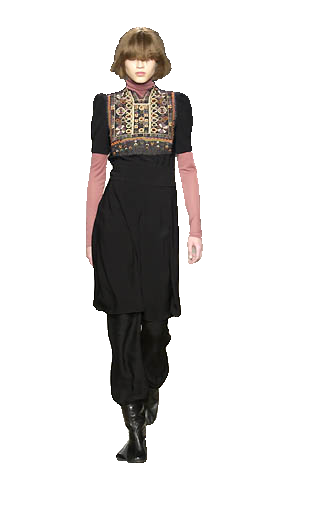

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


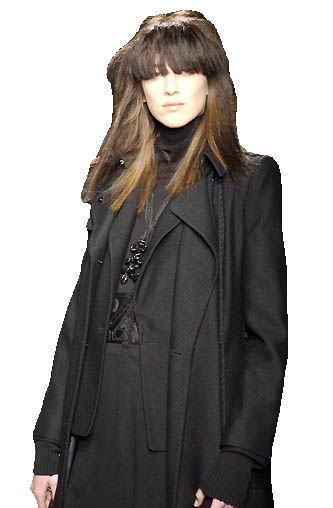

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


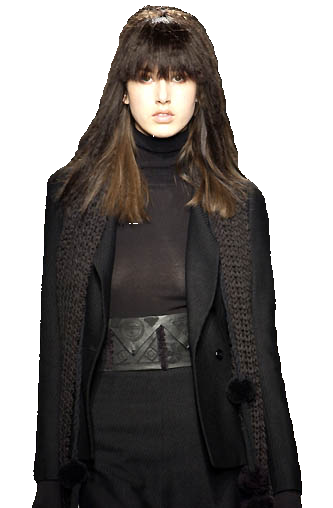

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


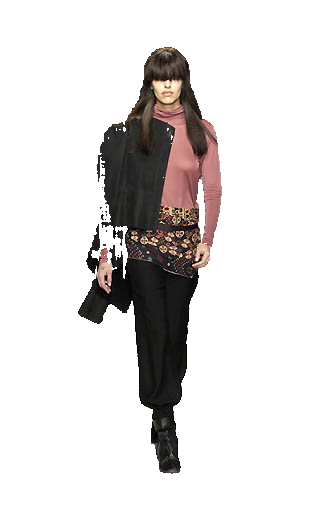

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


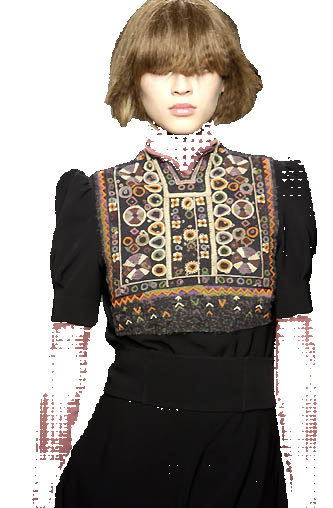

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


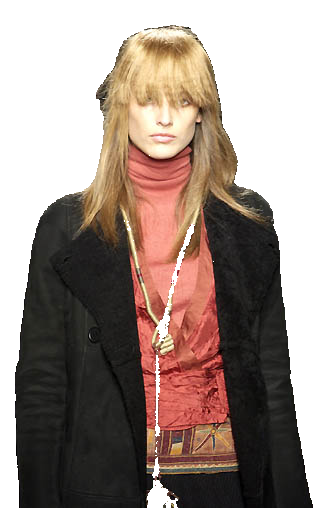

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


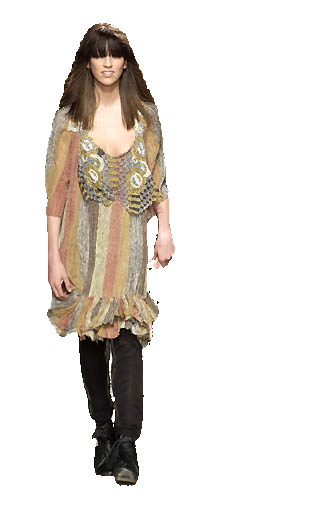

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


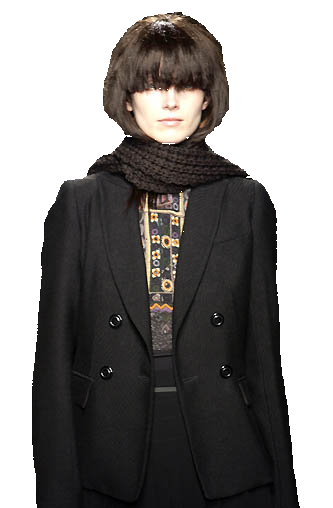

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


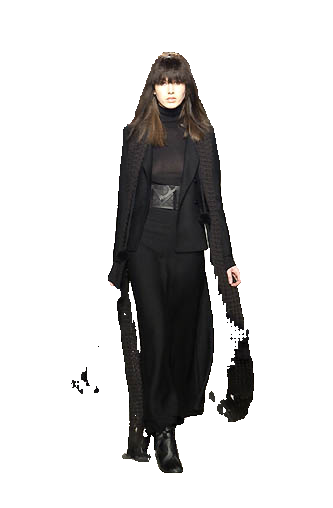

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


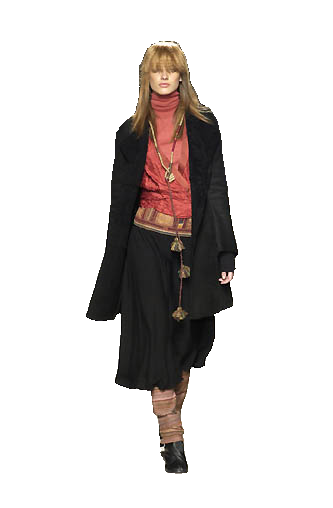

norm_threeD_mask.shape: (508, 333, 3)
image.shape: (508, 333, 3)


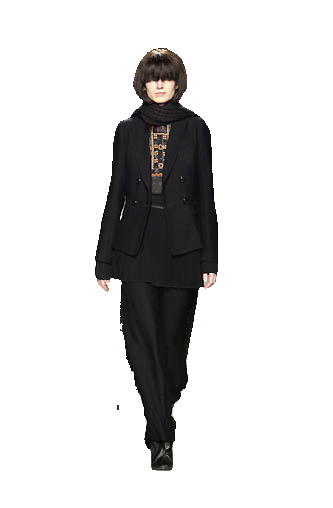

In [10]:
for image in images:
  create_mask(image[1], image[0])

### Part 2: Identifying top 10 colors from a collection

Combining all cutout images from one collection into one composite image

In [11]:
num_cutout_images = round(len([name for name in os.listdir('/content/fall-2002-ready-to-wear-isabel-marant')])/2)
image_1 = cv2.imread("/content/fall-2002-ready-to-wear-isabel-marant/0_cutout.png")
for image_idx in range(1, num_cutout_images):
  curr_path = "/content/fall-2002-ready-to-wear-isabel-marant/"+ str(image_idx)+"_cutout.png"
  curr_image = cv2.imread(curr_path)
  image_1 = np.concatenate((image_1, curr_image), axis=0)


Conducting Kmeans clustering on composite image to get top 10 colors

In [12]:
composite_image = image_1
composite_image = cv2.cvtColor(composite_image, cv2.COLOR_BGR2RGB)
clt = KMeans(n_clusters = 11, n_init='auto')
clt.fit(composite_image.reshape(-1, 3))

clt.cluster_centers_ = clt.cluster_centers_.reshape(1,11,3)
clt.cluster_centers_ = clt.cluster_centers_.round().astype(np.uint8)
clt.cluster_centers_ = clt.cluster_centers_.flatten()[3:].reshape(1,10,3)

Adding helper methods for comparing collections and for deprecated method for custom helper method

In [13]:
def patch_asscalar(a):
    return a.item()
setattr(np, "asscalar", patch_asscalar)

def given_two_rgb_arrays_return_delta_e(rgbarr1, rgbarr2):
  rgbarr1_Adobe = AdobeRGBColor(rgbarr1[0], rgbarr1[1], rgbarr1[2], is_upscaled=True)
  rgbarr2_Adobe = AdobeRGBColor(rgbarr2[0], rgbarr2[1], rgbarr2[2], is_upscaled=True)
  rgbarr1_Lab = convert_color(rgbarr1_Adobe, LabColor)
  rgbarr2_Lab = convert_color(rgbarr2_Adobe, LabColor)
  return delta_e_cie1976(rgbarr1_Lab, rgbarr2_Lab)

Converting the color clusters from two collections into a meaningful value that quantifies the difference (delte_e difference)

In [14]:
def delta_e_btwn_two_collections(collection1, collection2):
  collection1 = collection1.flatten()
  collection2 = collection2.flatten()
  new1 = []
  new2 = []
  for idx in range(0, len(collection1), 3):
    new1.append(collection1[idx:idx+3])
  for idx in range(0, len(collection2), 3):
    new2.append(collection2[idx:idx+3])
  total_diff = 0
  for rgb1 in new1:
    for rgb2 in new2:
        total_diff += given_two_rgb_arrays_return_delta_e(rgb1, rgb2)
  return total_diff/100

Example using the Fall 2013 Dolce & Gabanna collection

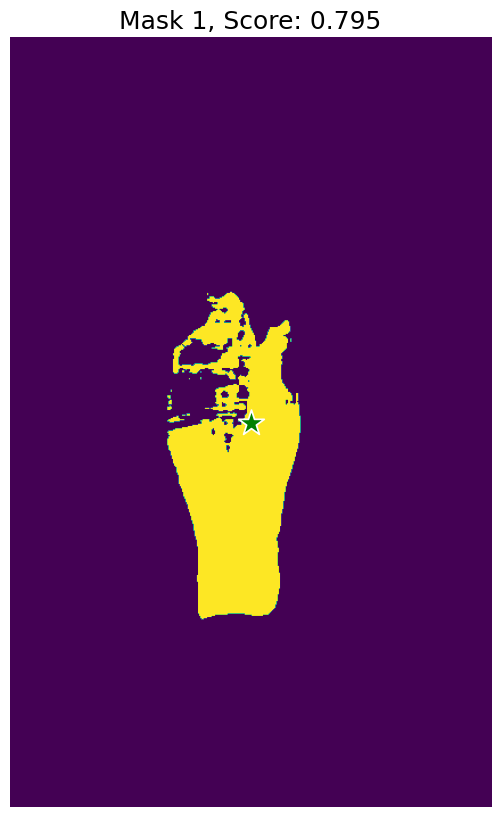

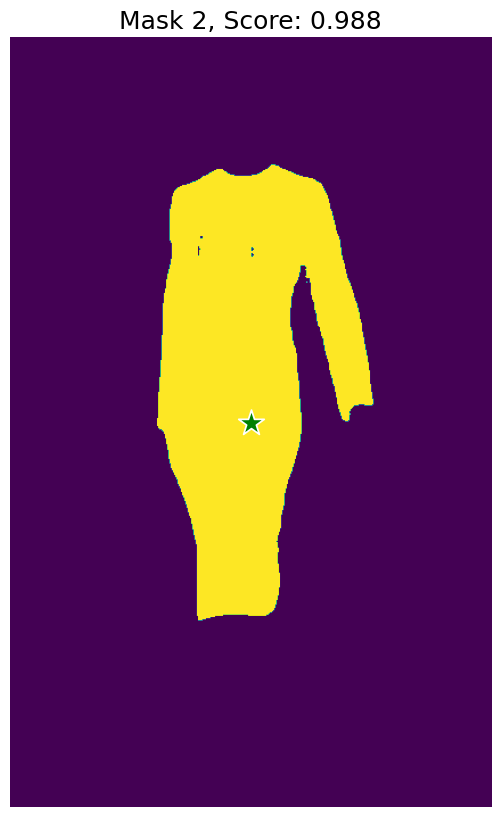

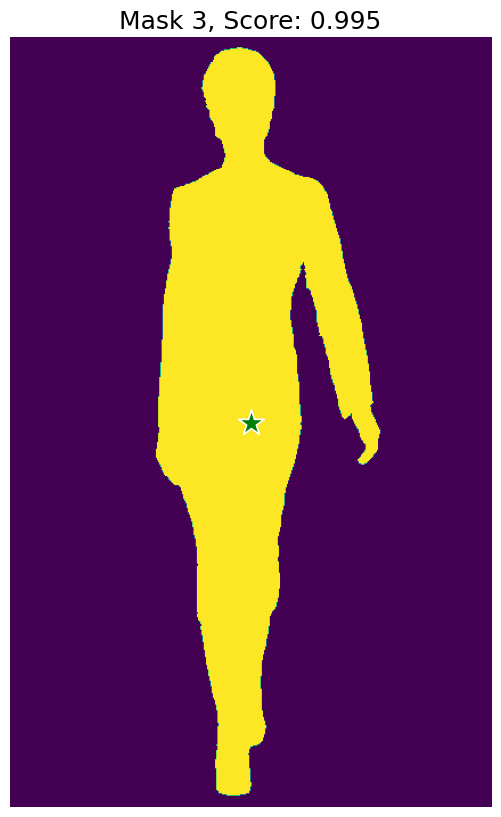

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


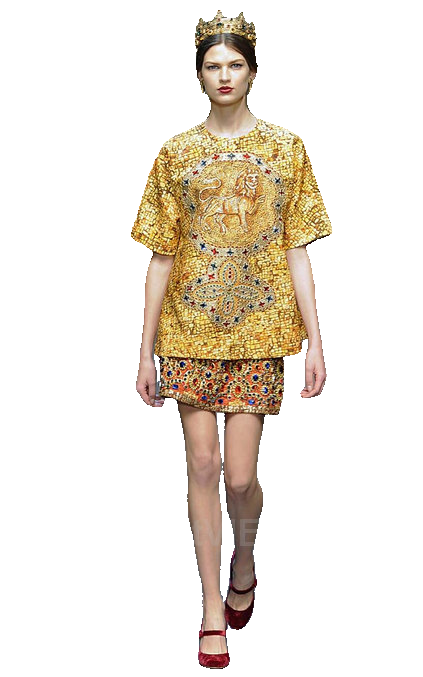

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


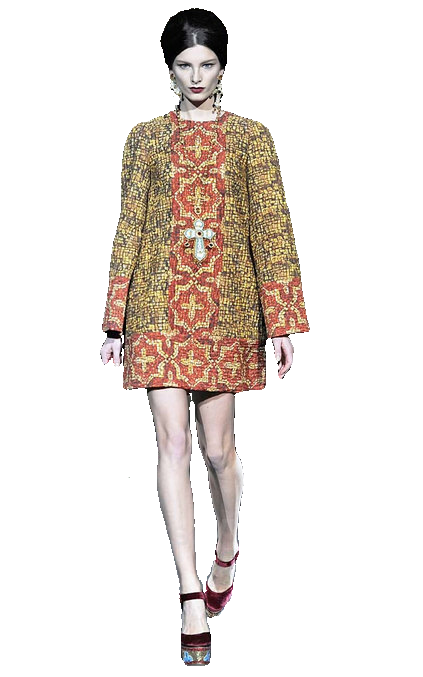

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


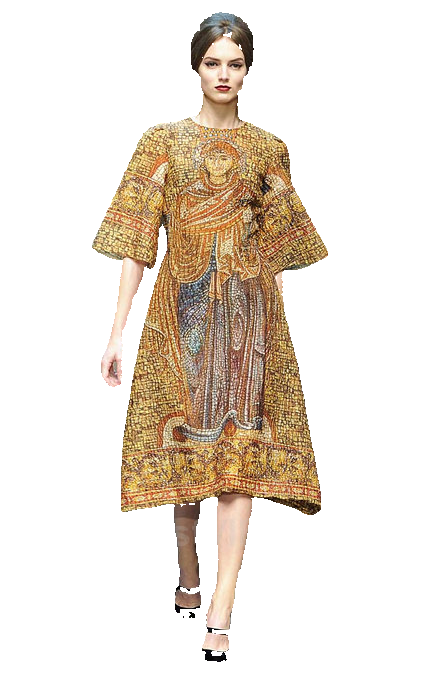

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


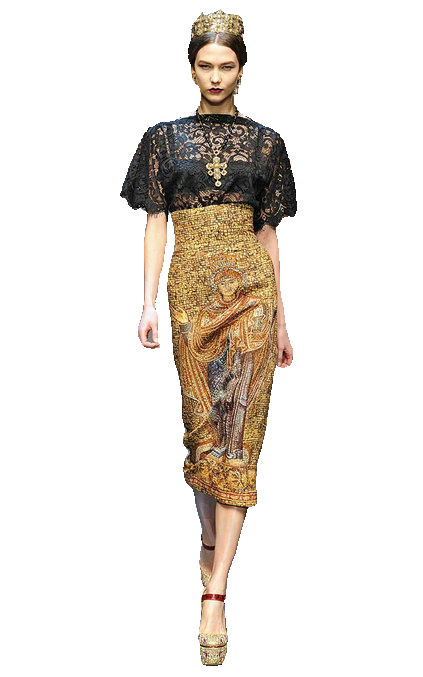

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


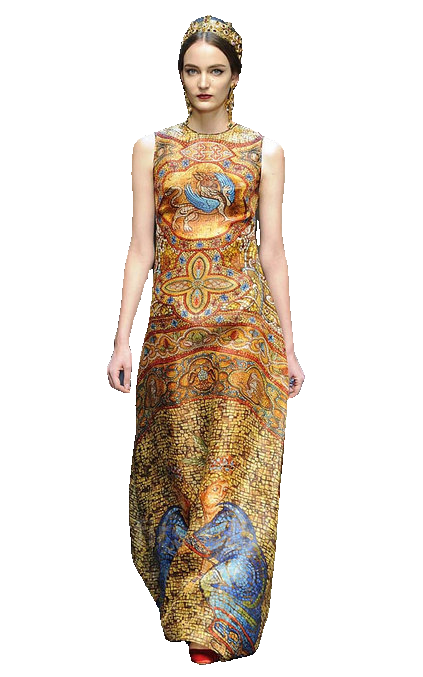

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


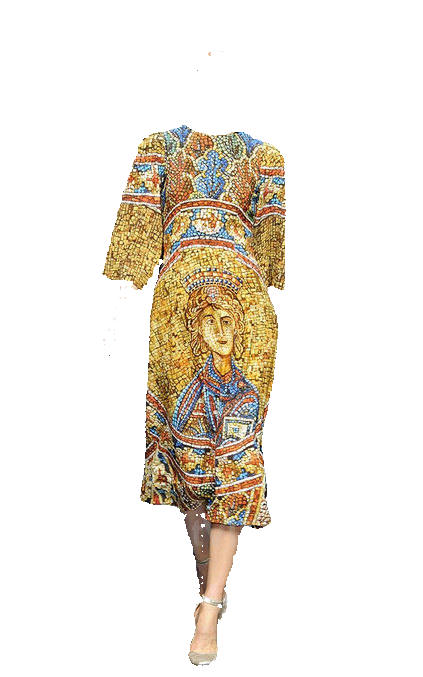

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


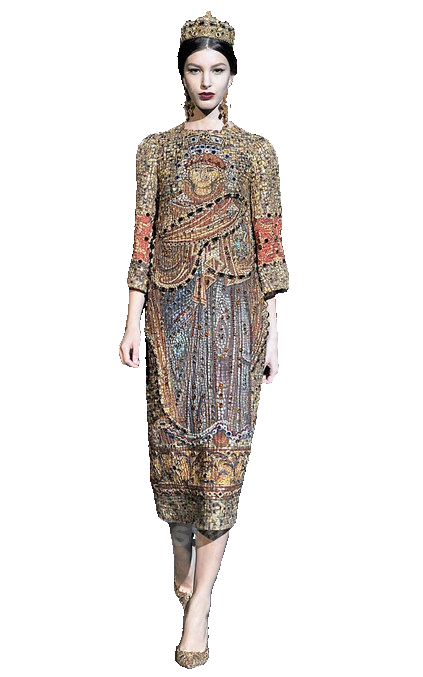

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


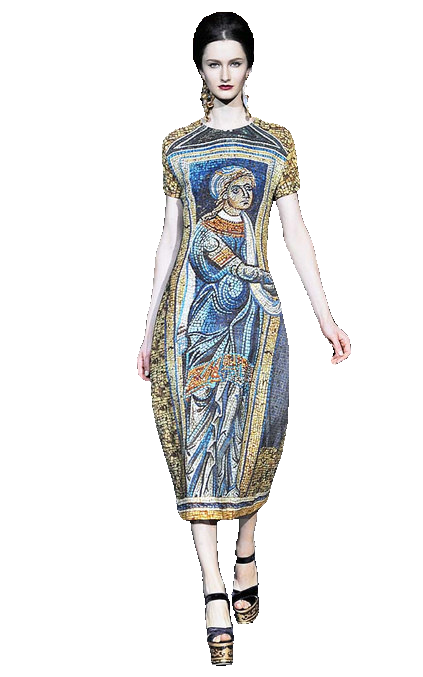

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


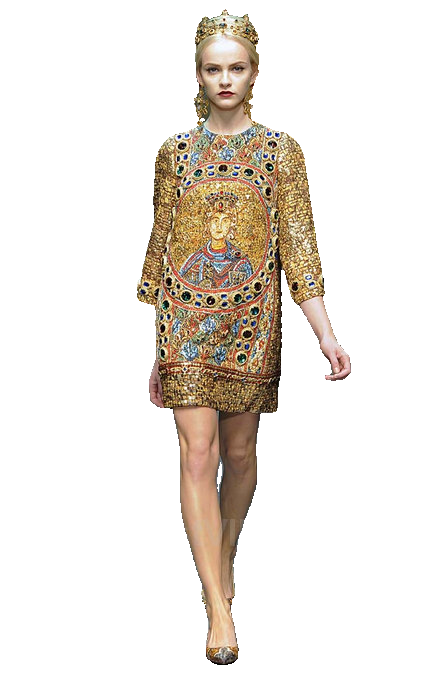

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


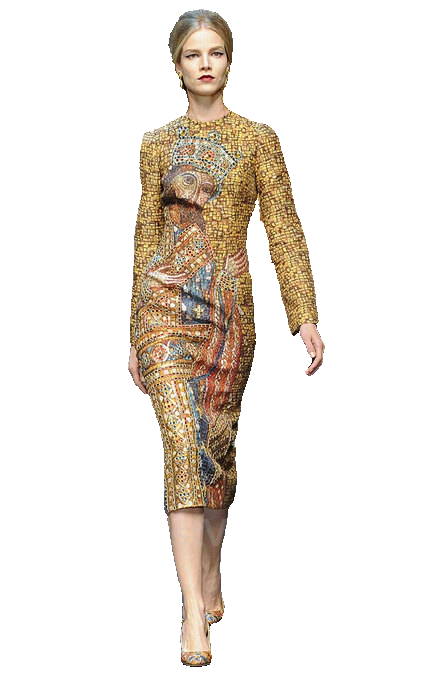

norm_threeD_mask.shape: (677, 423, 3)
image.shape: (677, 423, 3)


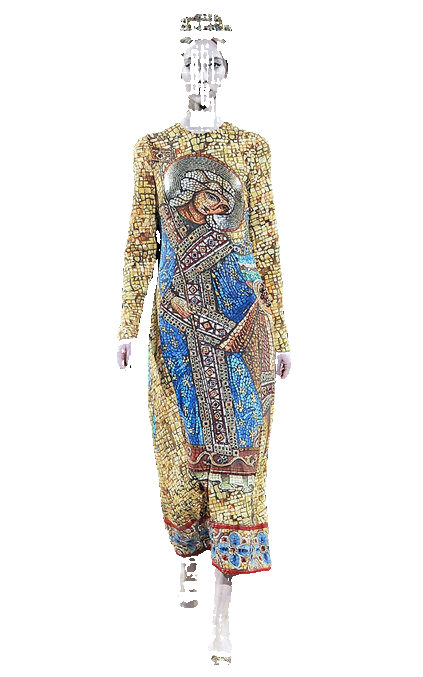

clt.cluster_centers_ [[[255 255 255]
  [ 80  78  80]
  [227 198 156]
  [102  64  33]
  [122 121 123]
  [ 39  27  21]
  [234 221 203]
  [203 166 119]
  [142 100  63]
  [166 169 170]]]


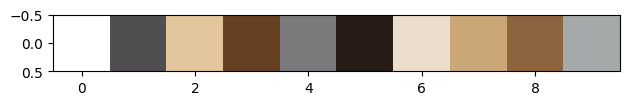

In [15]:
link_to_first_pic = "https://www.firstview.com/collection_image_closeup.php?of=0&collection=35178&image=4990167"
folder_name = "fall-2013-ready-to-wear-dolce-gabbana"
os.mkdir(folder_name)
retrieve_download(link_to_first_pic)
images = []
for file_name in os.listdir(folder_name):
  image_path = folder_name + '/' + file_name
  image_array = cv2.imread(image_path)
  images.append([image_path,image_array])
images[0][1].shape
image = images[9][1]
predictor.set_image(image)
input_point = np.array([[image.shape[1]/2, image.shape[0]/2]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
      point_coords=input_point,
      point_labels=input_label,
      multimask_output=True,
  )
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
for image in images:
  create_mask(image[1], image[0])
num_cutout_images = round(len([name for name in os.listdir('/content/' + folder_name)])/2)
image_1 = cv2.imread("/content/"+ folder_name +"/0_cutout.png")
for image_idx in range(1, num_cutout_images):
  curr_path = "/content/"+folder_name+"/"+ str(image_idx)+"_cutout.png"
  curr_image = cv2.imread(curr_path)
  image_1 = np.concatenate((image_1, curr_image), axis=0)
composite_image = image_1
composite_image = cv2.cvtColor(composite_image, cv2.COLOR_BGR2RGB)
clt = KMeans(n_clusters = 11, n_init='auto')
clt.fit(composite_image.reshape(-1, 3))
clt.cluster_centers_ = clt.cluster_centers_.reshape(1,11,3)
clt.cluster_centers_ = clt.cluster_centers_.round().astype(np.uint8)
clt.cluster_centers_ = clt.cluster_centers_.flatten()[3:].reshape(1,10,3)
print("clt.cluster_centers_", clt.cluster_centers_)
io.imshow(clt.cluster_centers_)
dg_cluster_centers = clt.cluster_centers_

Example using the Fall 2005 Alexander McQueen collection

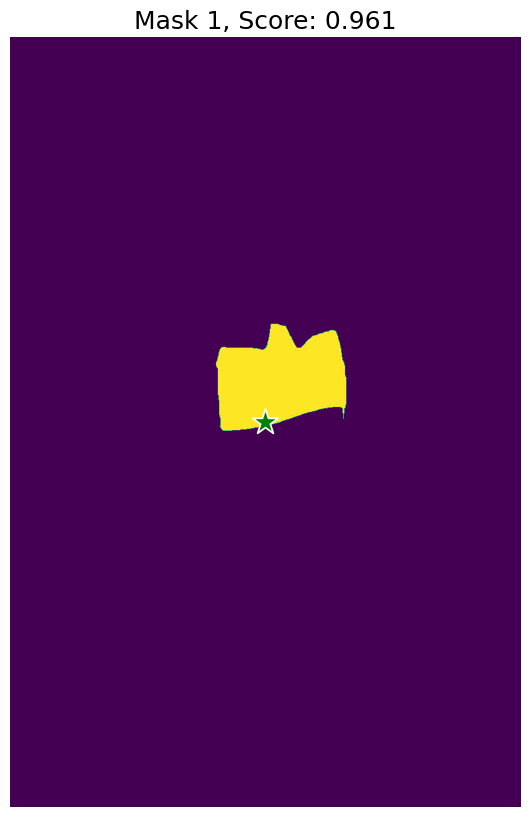

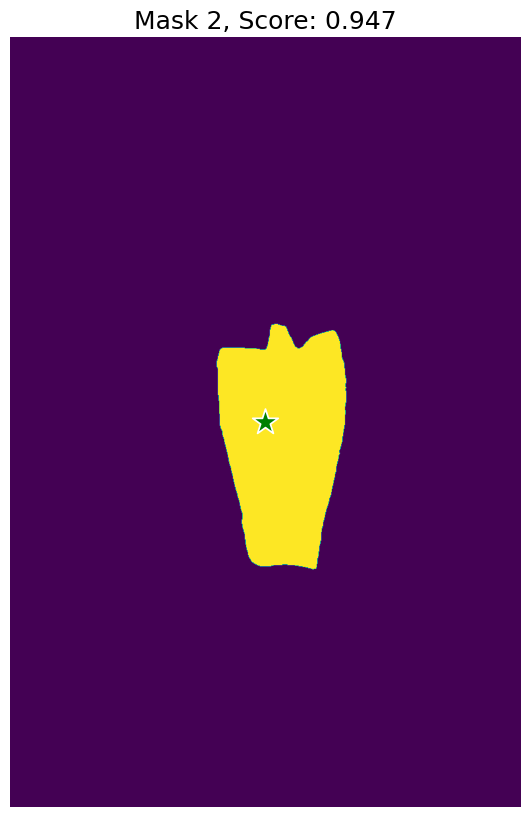

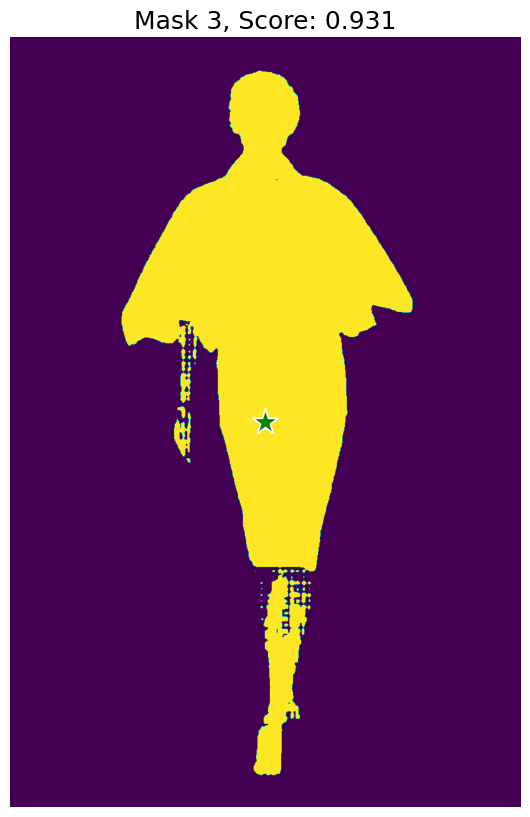

norm_threeD_mask.shape: (816, 542, 3)
image.shape: (816, 542, 3)


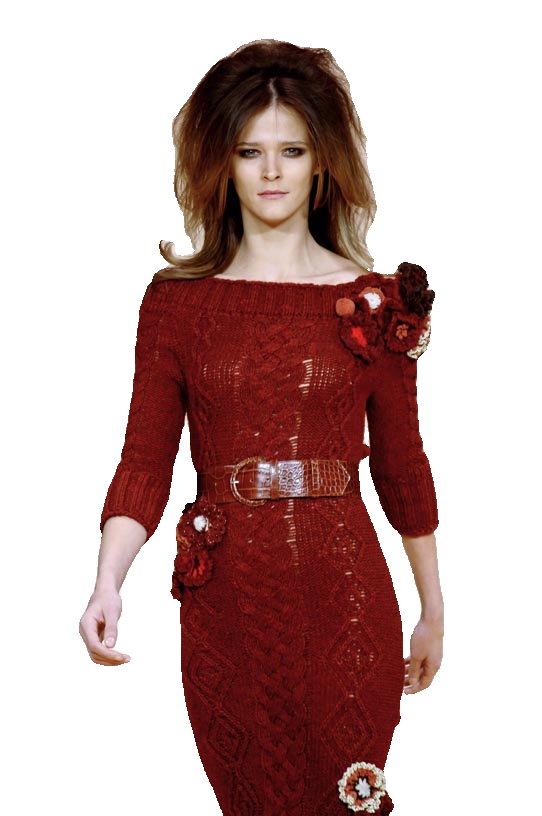

norm_threeD_mask.shape: (662, 439, 3)
image.shape: (662, 439, 3)


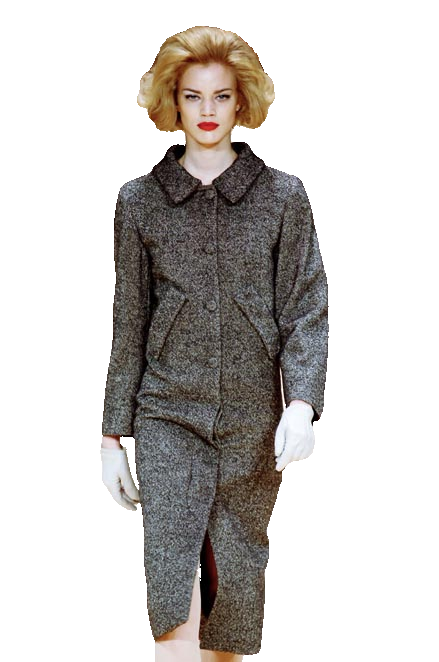

norm_threeD_mask.shape: (816, 541, 3)
image.shape: (816, 541, 3)


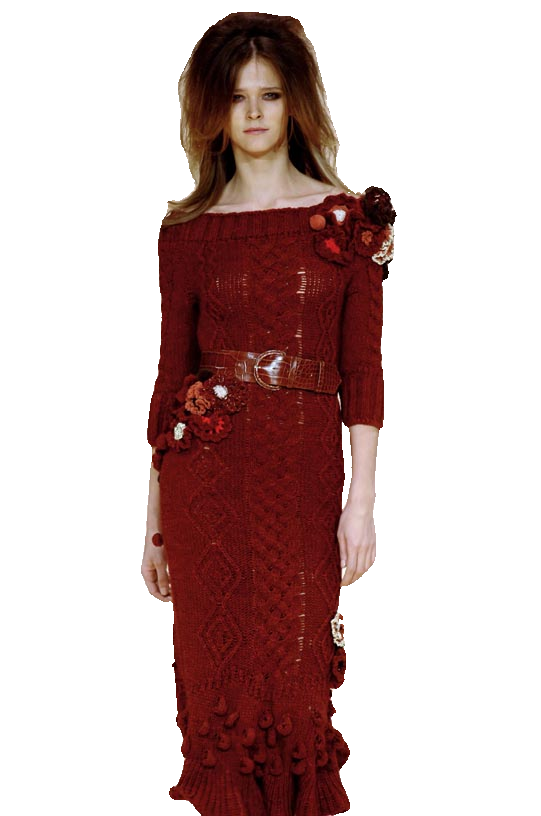

norm_threeD_mask.shape: (816, 542, 3)
image.shape: (816, 542, 3)


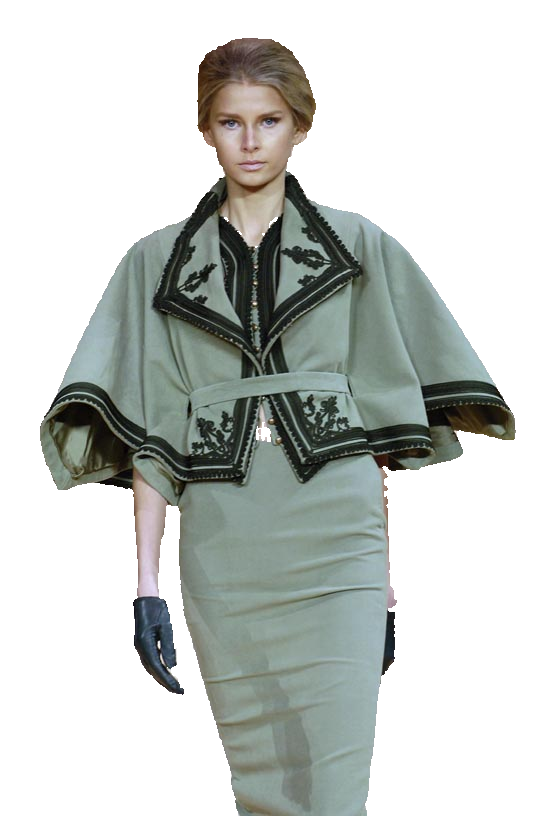

norm_threeD_mask.shape: (816, 542, 3)
image.shape: (816, 542, 3)


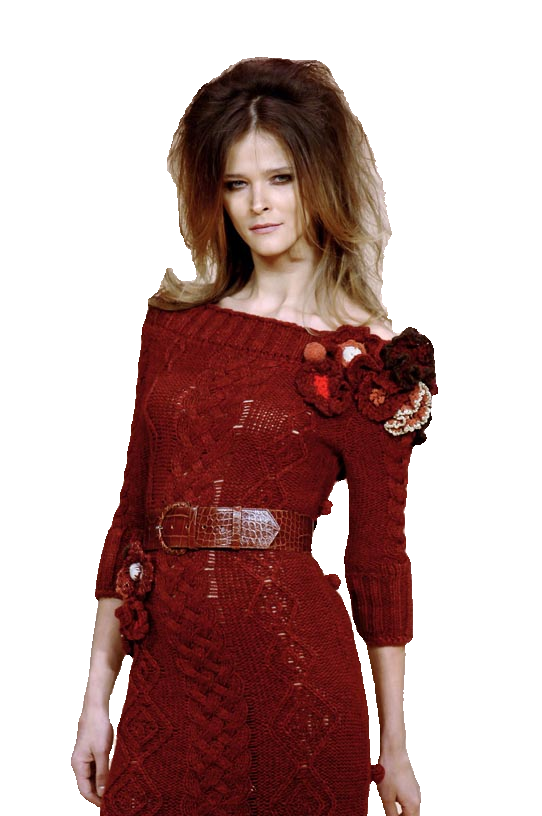

norm_threeD_mask.shape: (816, 542, 3)
image.shape: (816, 542, 3)


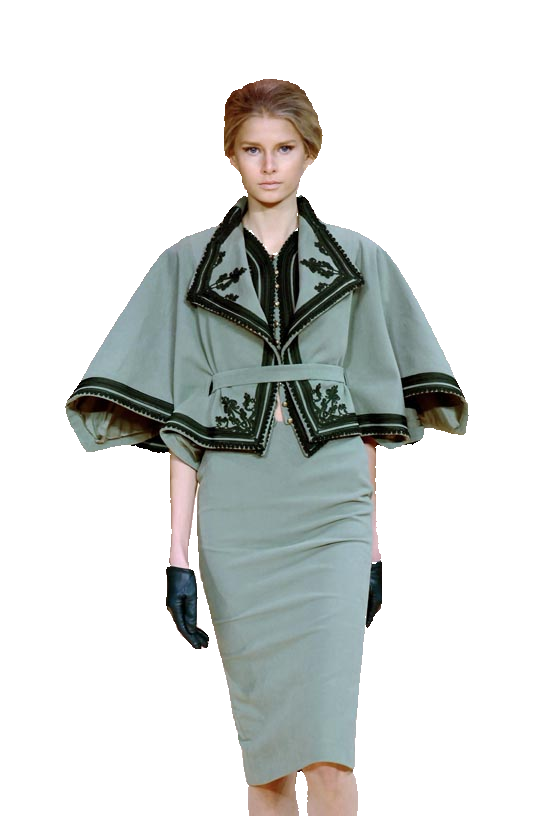

norm_threeD_mask.shape: (816, 542, 3)
image.shape: (816, 542, 3)


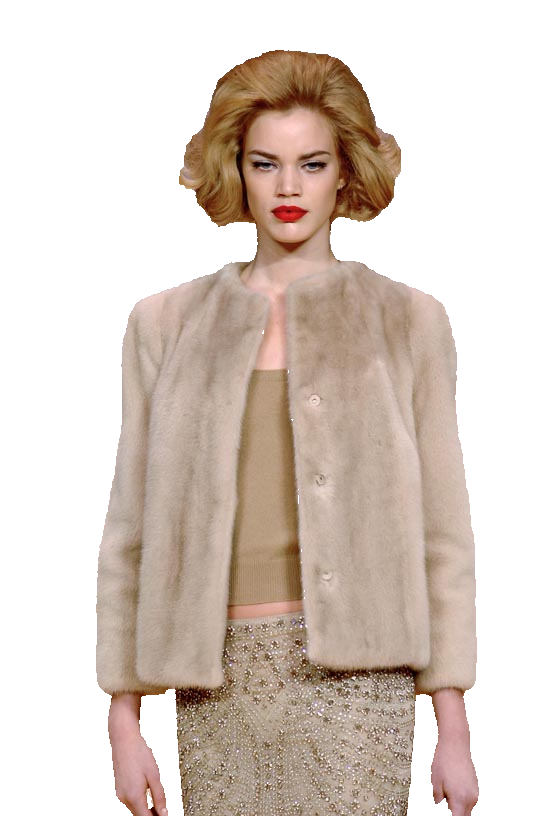

norm_threeD_mask.shape: (816, 542, 3)
image.shape: (816, 542, 3)


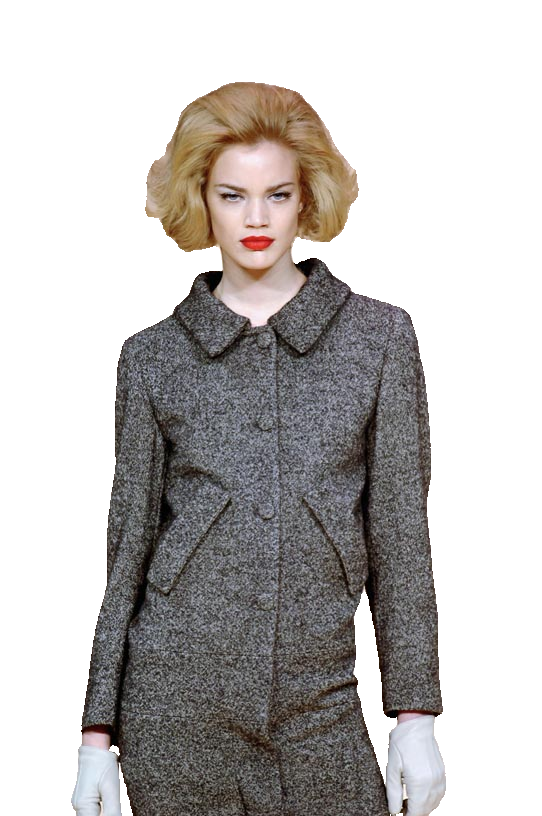

norm_threeD_mask.shape: (765, 507, 3)
image.shape: (765, 507, 3)


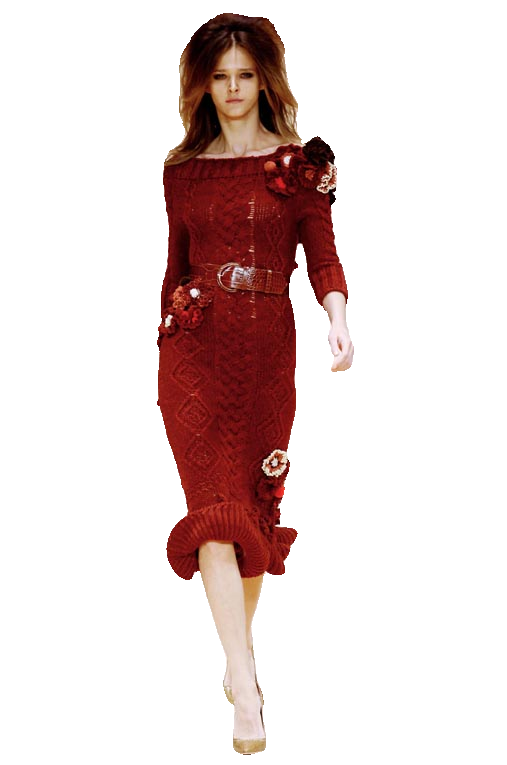

norm_threeD_mask.shape: (1232, 816, 3)
image.shape: (1232, 816, 3)


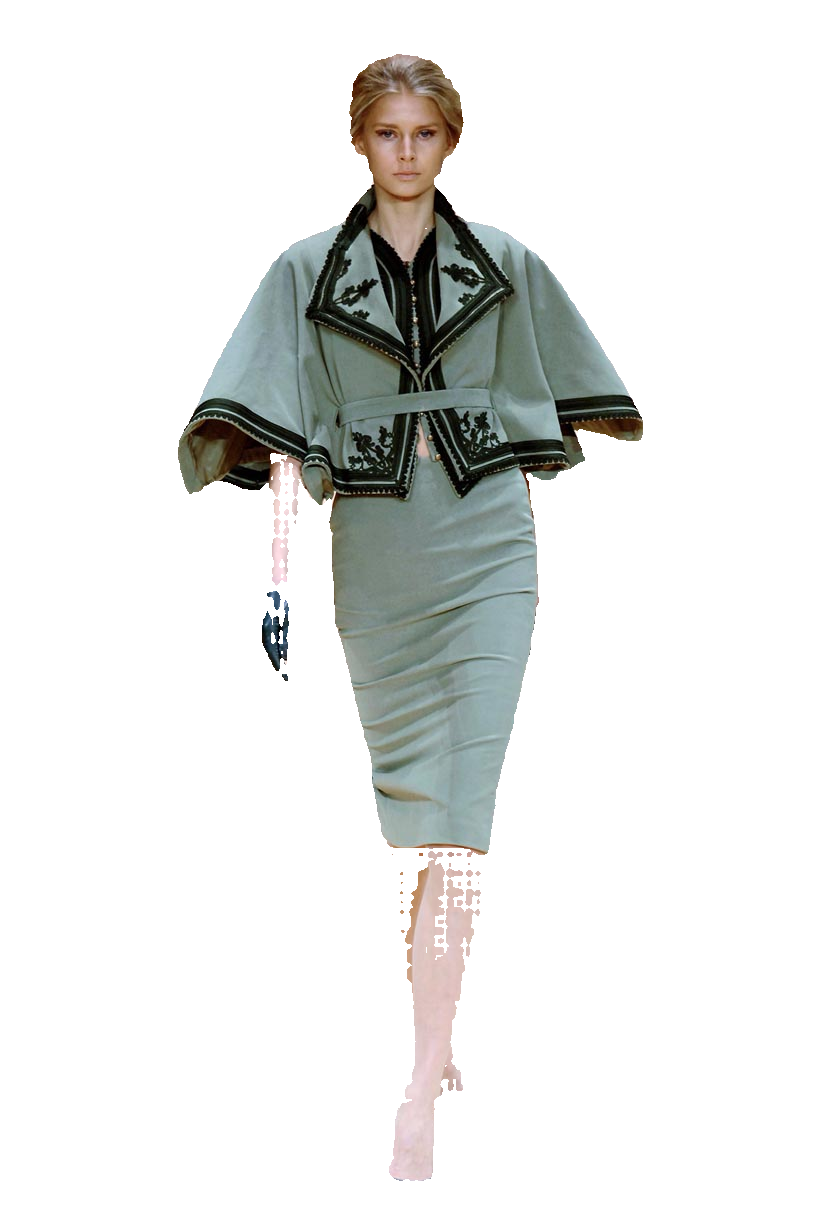

norm_threeD_mask.shape: (816, 542, 3)
image.shape: (816, 542, 3)


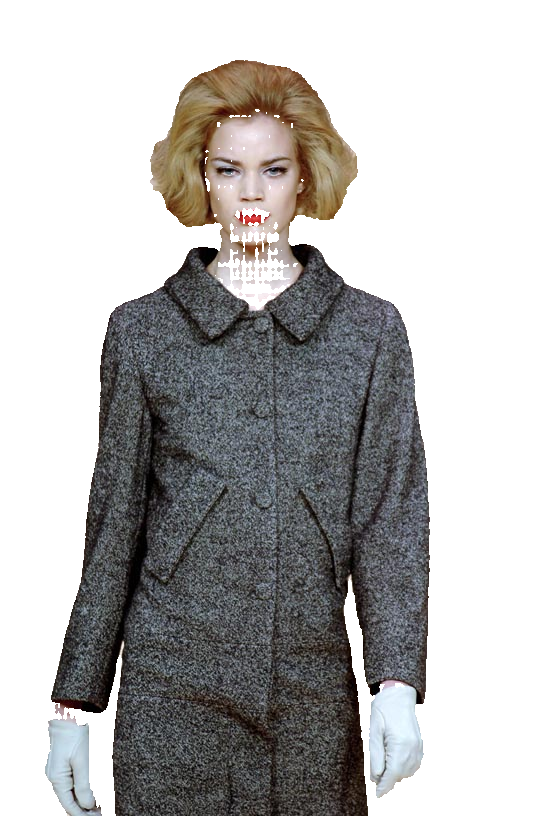

clt.cluster_centers_ [[[ 93  92  90]
  [ 62  59  55]
  [145 163 161]
  [120  40  28]
  [185 159 142]
  [ 90  15  14]
  [212 192 186]
  [151 114  81]
  [ 30  17  13]
  [122 127 125]]]


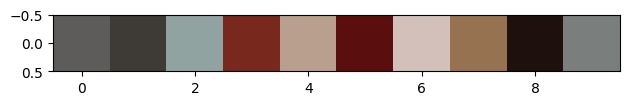

In [16]:
link_to_first_pic = "https://www.firstview.com/collection_image_closeup.php?of=0&collection=7355&image=1077903"
folder_name = "fall-2005-ready-to-wear-alexander-mcqueen"
os.mkdir(folder_name)
retrieve_download(link_to_first_pic)
images = []
for file_name in os.listdir(folder_name):
  image_path = folder_name + '/' + file_name
  image_array = cv2.imread(image_path)
  images.append([image_path,image_array])
images[0][1].shape
image = images[9][1]
predictor.set_image(image)
input_point = np.array([[image.shape[1]/2, image.shape[0]/2]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
      point_coords=input_point,
      point_labels=input_label,
      multimask_output=True,
  )
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
for image in images:
  create_mask(image[1], image[0])
num_cutout_images = round(len([name for name in os.listdir('/content/' + folder_name)])/2)
image_1 = cv2.imread("/content/"+ folder_name +"/0_cutout.png")
standard_shape = image_1.shape[0:2]
for image_idx in range(1, num_cutout_images):
  curr_path = "/content/"+folder_name+"/"+ str(image_idx)+"_cutout.png"
  curr_image = cv2.imread(curr_path)
  curr_image = cv2.resize(curr_image, standard_shape[::-1])
  image_1 = np.concatenate((image_1, curr_image), axis=0)
composite_image = image_1
composite_image = cv2.cvtColor(composite_image, cv2.COLOR_BGR2RGB)
clt = KMeans(n_clusters = 11, n_init='auto')
clt.fit(composite_image.reshape(-1, 3))
clt.cluster_centers_ = clt.cluster_centers_.reshape(1,11,3)
clt.cluster_centers_ = clt.cluster_centers_.round().astype(np.uint8)
clt.cluster_centers_ = clt.cluster_centers_.flatten()[3:].reshape(1,10,3)
print("clt.cluster_centers_", clt.cluster_centers_)
io.imshow(clt.cluster_centers_)
am_cluster_centers = clt.cluster_centers_

Displaying the top 10 most frequent colors for each collection

In [17]:
im_cluster_centers = np.array([[[ 92,  77,  69], [200, 147, 113], [ 25,  22,  21], [161, 105,  76], [199, 180, 157], [ 43,  39,  38], [237, 218, 192], [154, 137, 121], [120, 102,  92], [ 64,  57,  54]]])

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


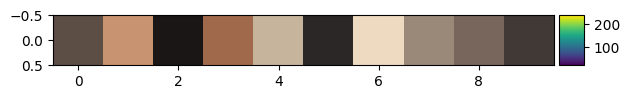

In [18]:
io.imshow(im_cluster_centers)

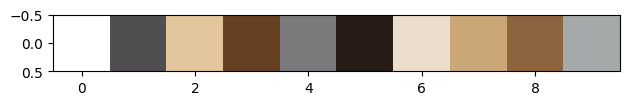

In [19]:
io.imshow(dg_cluster_centers)

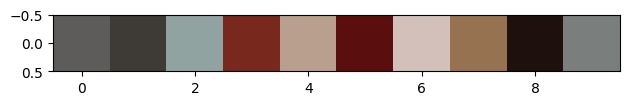

In [20]:
io.imshow(am_cluster_centers)

Comparing the delta_e difference between two collections, where lower values indicate more similar collections

In [21]:
print("Difference between Isabel Marant and Dolce & Gabanna collections:", delta_e_btwn_two_collections(im_cluster_centers, dg_cluster_centers))
print("Difference between Isabel Marant and Alexander McQueen collections:", delta_e_btwn_two_collections(im_cluster_centers, am_cluster_centers))
print("Difference between Alexander McQueen and Dolce & Gabanna collections:", delta_e_btwn_two_collections(am_cluster_centers, dg_cluster_centers))

Difference between Isabel Marant and Dolce & Gabanna collections: 39.945404014813796
Difference between Isabel Marant and Alexander McQueen collections: 38.50743165428581
Difference between Alexander McQueen and Dolce & Gabanna collections: 42.375678815909204
